In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [28]:
# Load dataset
def load_data(filepath):
    df = pd.read_csv(filepath, sep=';', na_values=['?'])

    # Read CSV, parse Date & Time columns into a single datetime index
    df = pd.read_csv(filepath, sep=';', parse_dates=[['Date', 'Time']], na_values=['?'])

    # Rename the new combined column to 'Datetime'
    df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)

    # Set Datetime as index
    df.set_index('Datetime', inplace=True)

    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek + 1  # Convert to numeric format (Sunday=1, Monday=2, etc.)
    df['time_float'] = df.index.hour + df.index.minute / 60.0  # Convert to decimal format

    # Handling missing values
    df.dropna(subset=['Global_active_power'], inplace=True)  # Drop rows with NaN target

    # Convert all numeric columns to float
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric values to NaN

    return df


In [29]:
# Explore dataset
def explore_data(df):
    print("Data Head:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Plot correlation heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title("Feature Correlation Heatmap")
    plt.show()

    # Detect outliers using IQR method
    print("\nOutliers Detection using IQR:")
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outlier_mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
    outliers = outlier_mask.sum()
    
    print(outliers[outliers > 0])  # Print columns with outliers and their count

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df)
    plt.xticks(rotation=45)
    plt.title("Boxplot for Outlier Detection")
    plt.show()

In [44]:
# Feature engineering
def preprocess_data(df):
    
    # Selecting features and target
    # X is feature
    # y is target
    y = df['Global_active_power']    
    X = df.drop('Global_active_power', axis=1)  # Drop only existing columns
    
    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scaling data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns

In [31]:
# Train model function
def train_model(X_train, y_train, model_type="random_forest"):
    if model_type == "random_forest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == "linear_regression":
        model = LinearRegression()
    elif model_type == "gradient_boosting":
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose from 'random_forest', 'linear_regression', 'gradient_boosting'.")
    
    model.fit(X_train, y_train)
    return model

In [32]:
# Feature importance
def feature_importance(model, feature_names):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    print("\nFeature Importance Ranking:")
    print(feature_importance_df)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title("Feature Importance")
    plt.show()

In [33]:
# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"R2 Score: {r2_score(y_test, y_pred)}")
    
    # Plot predictions
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values[:100], label='Actual')
    plt.plot(y_pred[:100], label='Predicted')
    plt.legend()
    plt.title("Actual vs Predicted Energy Consumption")
    plt.show()

In [34]:
df = load_data(r"C:\Users\svasuda\OneDrive - Daimler Truck\Visual Studio Python projects\AI ML\Energy Consumption\individual+household+electric+power+consumption\household_power_consumption.txt")

C:\Users\svasuda\AppData\Local\Temp\ipykernel_33184\93678090.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(filepath, sep=';', parse_dates=[['Date', 'Time']], na_values=['?'])
C:\Users\svasuda\AppData\Local\Temp\ipykernel_33184\93678090.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(filepath, sep=';', parse_dates=[['Date', 'Time']], na_values=['?'])


Data Head:
                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:0

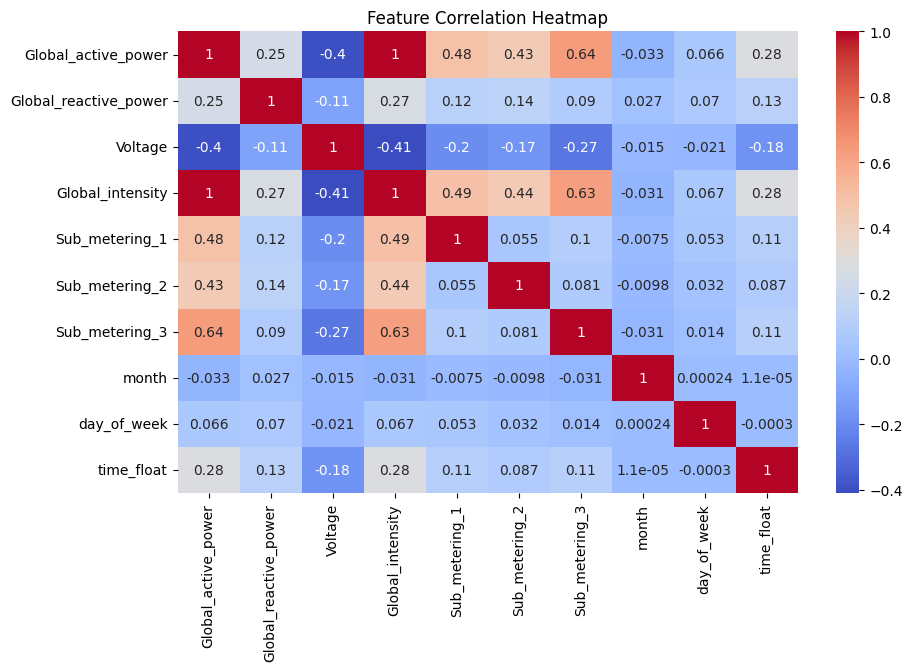


Outliers Detection using IQR:
Global_active_power       94907
Global_reactive_power     40420
Voltage                   51067
Global_intensity         100961
Sub_metering_1           169105
Sub_metering_2            77151
dtype: int64


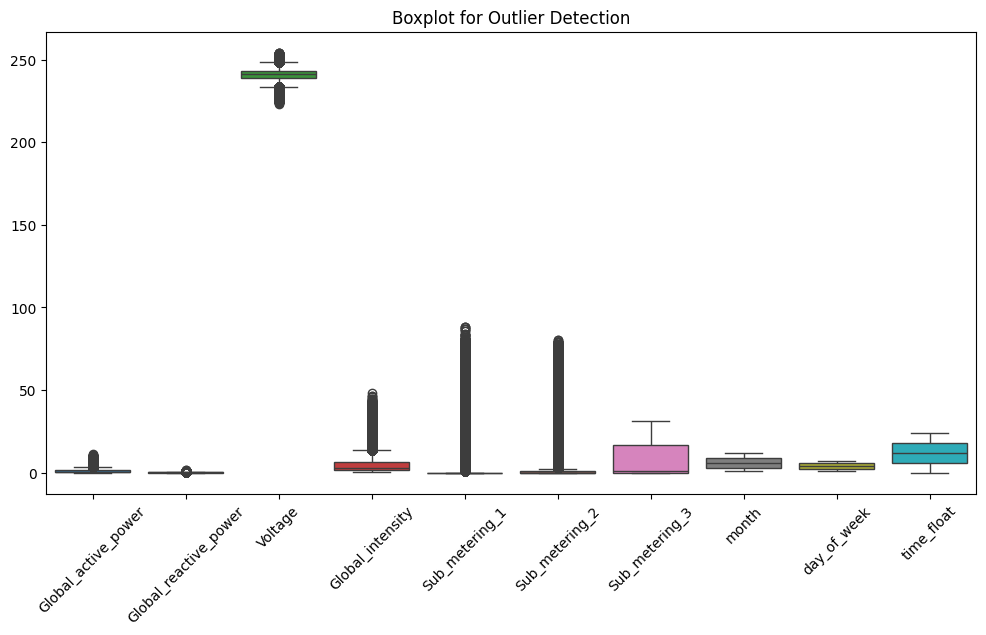

In [35]:
explore_data(df)

In [45]:
X_train, X_test, y_train, y_test, feature_names = preprocess_data(df)

In [37]:
model = train_model(X_train, y_train, "linear_regression")

MAE: 0.025751204527429322
RMSE: 0.040253396876481905
R2 Score: 0.998558347473717


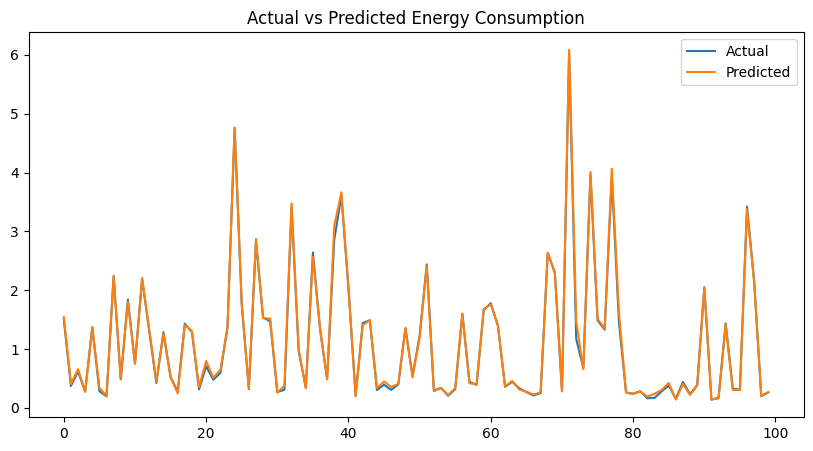

In [38]:
evaluate_model(model, X_test, y_test)

In [39]:
model = train_model(X_train, y_train, "gradient_boosting")

MAE: 0.0210136489343944
RMSE: 0.03381819356326145
R2 Score: 0.9989824486424013


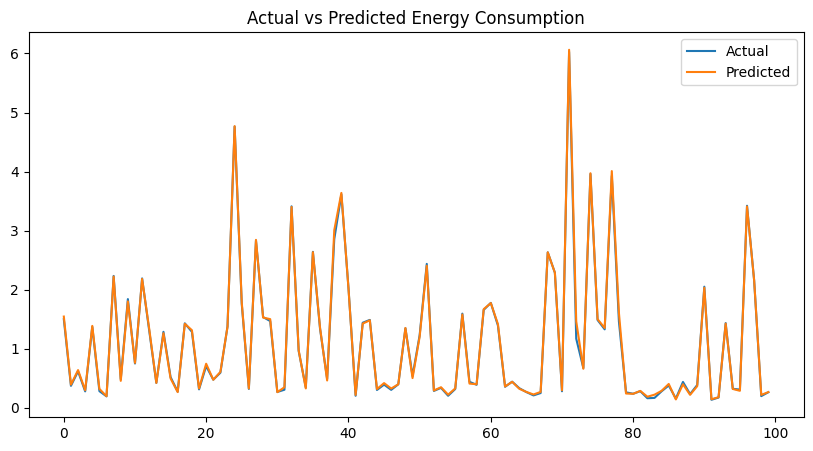

In [40]:
evaluate_model(model, X_test, y_test)

In [41]:
model = train_model(X_train, y_train, "random_forest")

MAE: 0.012456027106500593
RMSE: 0.025876675775104673
R2 Score: 0.9994042384159462


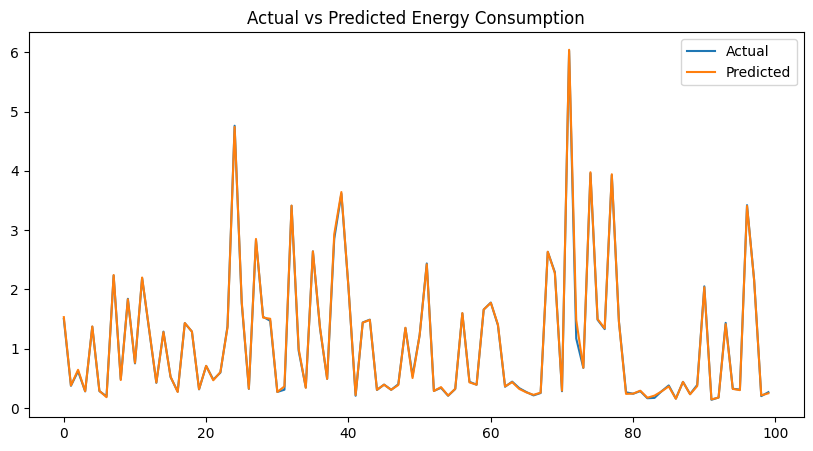

In [42]:
evaluate_model(model, X_test, y_test)


Feature Importance Ranking:
                 Feature  Importance
2       Global_intensity    0.998156
0  Global_reactive_power    0.000461
1                Voltage    0.000447
8             time_float    0.000255
3         Sub_metering_1    0.000230
5         Sub_metering_3    0.000156
6                  month    0.000129
7            day_of_week    0.000084
4         Sub_metering_2    0.000081


C:\Users\svasuda\AppData\Local\Temp\ipykernel_33184\3885092054.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


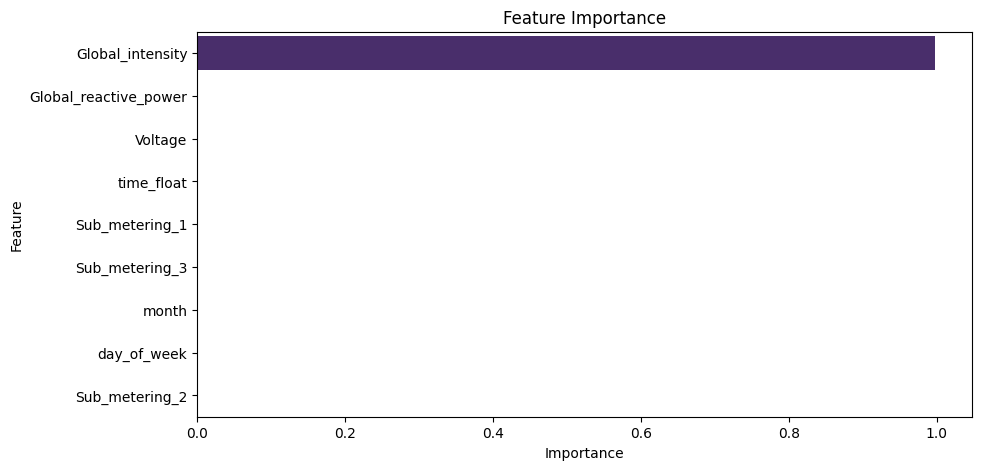

In [46]:
feature_importance(model, feature_names)